### Library

In [1]:
import torch
from torch import nn, optim
from torch.utils.data import TensorDataset, DataLoader
from torch.nn import Module
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from torchsummary import summary
import os
from torchvision import datasets, transforms
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

### Download Path

In [2]:
Download_DataPath = os.path.join(os.getcwd(),'Data')

### Load  - Transoform - Normalize MINST Dateset

In [3]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
training_dataset = datasets.MNIST(root = Download_DataPath, train = True, transform = transform, download = True)

### Prepare - Shuffle Data Batches

In [4]:
training_loader = DataLoader(dataset = training_dataset, shuffle = True, batch_size = 100)

#### Transofrom Tesnor Image
- Tensor Image Of Shape (1, 28, 28) to (28, 28, 1)
- Remove Normalization
- Set Value Range From 0 -> 1 Instead Of -1 -> 1

In [5]:
def im_convert(tensor):
    image = tensor.clone().detach().numpy() # Get Clone From The Tensor And Transfer To Numpy Array
    image = image.transpose(1, 2, 0) # Fix ARray Shape From (1, 28, 28) to (28, 28, 1) To Be Feeded Well To The Network ( Model )
    #print(image.shape)
    image = image * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5)) # Remove Normalization
    image = image.clip(0, 1) # Clip Every -1 to 0 and Every 1 to 1 In The Array
    return image

### Load Data In Batches

In [6]:
dataIter = iter(training_loader) # Move Through Data Batches 
images, labels = next(dataIter) #( Load Batche One By One Mean Load Every 100 Image )

### Plot First 20 Image

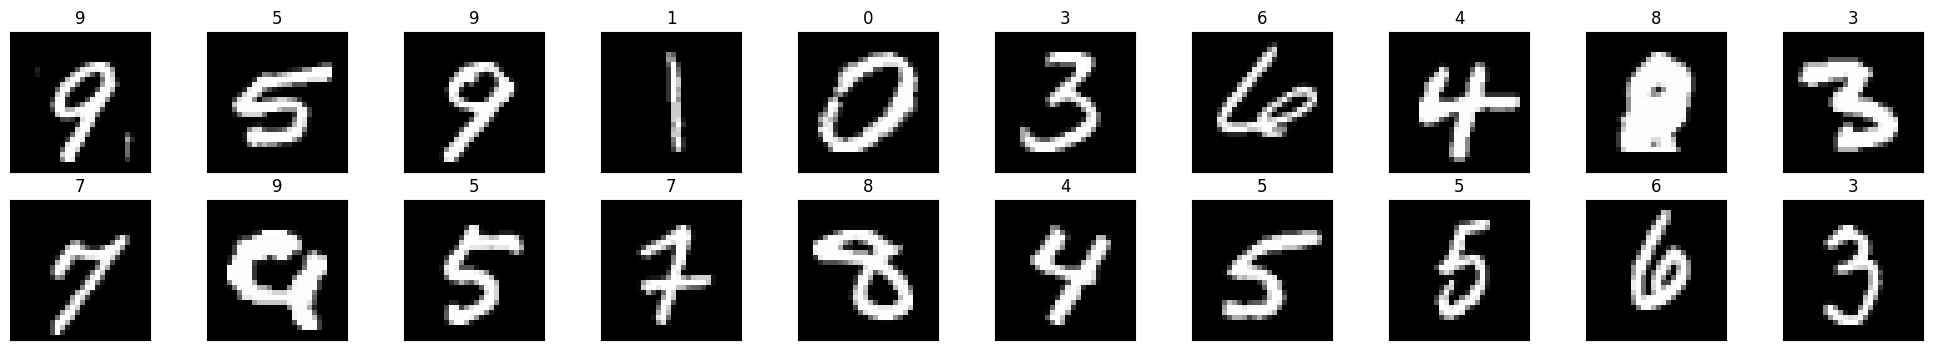

In [7]:
fig = plt.figure(figsize = (25, 4))
for idx in range(20):
    ax = fig.add_subplot(2, 10, idx+1, xticks = [], yticks = [])
    plt.imshow(im_convert(images[idx]))
    ax.set_title(labels[idx].item())

### Create Model

In [8]:
class ImageClassifier(Module):
    def __init__(self, input_size, h1_size, h2_size, output_size):
        super().__init__()
        self.linear1 = nn.Linear(in_features = input_size, out_features = h1_size)
        self.linear2 = nn.Linear(in_features = h1_size, out_features = h2_size)
        self.linear3 = nn.Linear(in_features = h2_size, out_features = output_size)

    def forward(self, x):
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        x = self.linear3(x)
        return x

In [9]:
model = ImageClassifier(input_size = 784, h1_size = 125, h2_size = 65, output_size = 10)

In [10]:
model.state_dict()

OrderedDict([('linear1.weight',
              tensor([[-0.0165,  0.0204, -0.0275,  ...,  0.0030,  0.0032,  0.0243],
                      [ 0.0141, -0.0277,  0.0357,  ..., -0.0097, -0.0051, -0.0094],
                      [ 0.0084, -0.0311,  0.0013,  ..., -0.0349, -0.0218,  0.0018],
                      ...,
                      [-0.0063, -0.0331, -0.0237,  ...,  0.0266, -0.0043,  0.0031],
                      [-0.0204,  0.0170, -0.0203,  ..., -0.0319,  0.0132, -0.0130],
                      [-0.0066,  0.0312, -0.0244,  ..., -0.0308, -0.0080, -0.0159]])),
             ('linear1.bias',
              tensor([ 2.1184e-02,  1.9790e-02,  3.3787e-02, -2.1383e-02,  1.7789e-02,
                      -1.7760e-02,  3.3906e-02, -2.3650e-02, -3.2011e-02,  6.1703e-03,
                       2.4320e-02, -1.4509e-02, -1.0439e-02, -3.0937e-02, -5.2484e-03,
                      -1.5316e-02,  5.0930e-03, -9.2206e-03, -3.0433e-02, -2.7198e-02,
                       1.0714e-02,  2.6961e-02, -3.2970e

In [11]:
summary(model, (784,))

Layer (type:depth-idx)                   Output Shape              Param #
├─Linear: 1-1                            [-1, 125]                 98,125
├─Linear: 1-2                            [-1, 65]                  8,190
├─Linear: 1-3                            [-1, 10]                  660
Total params: 106,975
Trainable params: 106,975
Non-trainable params: 0
Total mult-adds (M): 0.11
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.41
Estimated Total Size (MB): 0.41


Layer (type:depth-idx)                   Output Shape              Param #
├─Linear: 1-1                            [-1, 125]                 98,125
├─Linear: 1-2                            [-1, 65]                  8,190
├─Linear: 1-3                            [-1, 10]                  660
Total params: 106,975
Trainable params: 106,975
Non-trainable params: 0
Total mult-adds (M): 0.11
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.41
Estimated Total Size (MB): 0.41

### Loss Function , Optimizer

In [12]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.01)

### Train The Model

In [13]:
epochs = 12
running_loss_history = []
running_correct_history = []

for epoch in range(epochs):
    running_loss = 0.0
    running_correct = 0.0
    for inputs, labels in training_loader:
        inputs = inputs.view(inputs.shape[0], -1) #(100, 784 = 28*28)
        outputs = model(inputs)

        loss = criterion(outputs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        _, pred = torch.max(outputs, 1) # max score from outputs scores [0 -> 1] Cross Entropy with softmax
        running_loss += loss.item() # the current loss at the batch iteration
        running_correct += torch.sum(pred == labels.data)
    else:
        epoch_loss = running_loss / len(training_loader) # avg epoch loss
        epoch_acc = running_correct.float() / len(training_loader) # avg epoch accuracy
        running_loss_history.append(epoch_loss)
        running_correct_history.append(epoch_acc)
        print('epoch loss {:.4f},   epoch accuracy {:.4f}'.format(epoch_loss, epoch_acc.item()))


epoch loss 0.4063,   epoch accuracy 87.2817
epoch loss 0.2353,   epoch accuracy 92.9183
epoch loss 0.2133,   epoch accuracy 93.6333
epoch loss 0.2027,   epoch accuracy 93.9967
epoch loss 0.1962,   epoch accuracy 94.2167
epoch loss 0.1908,   epoch accuracy 94.4200
epoch loss 0.1835,   epoch accuracy 94.7450
epoch loss 0.1744,   epoch accuracy 95.0217
epoch loss 0.1750,   epoch accuracy 94.9933
epoch loss 0.1708,   epoch accuracy 95.1883
epoch loss 0.1700,   epoch accuracy 95.2083
epoch loss 0.1660,   epoch accuracy 95.4217


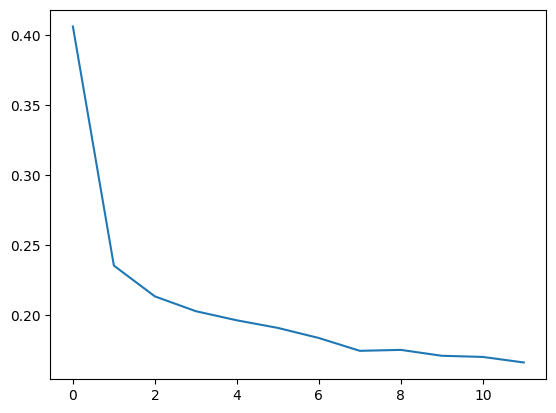

In [18]:
plt.plot(running_loss_history, label = 'Trainig Losses')

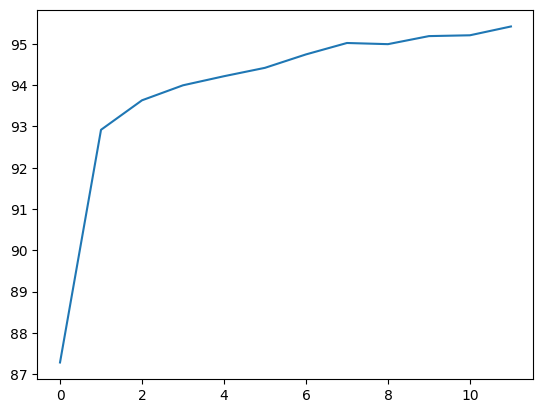

In [19]:
plt.plot(running_correct_history, label = 'Trainig Losses')